In [77]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.interpolate
import scipy.optimize

In [78]:
def mW_to_dBm(pwr_mW):
    return 10*np.log10(pwr_mW)

def dBm_to_mW(pwr_dBm):
    return 10**(pwr_dBm/10)

## Power Stabilization

In [106]:
path = "/home/polocalc/Documents/lab_test_scripts/diode_responsivity/HP diode/93GHz/"
folder_name = glob.glob(path + "*12_51_58_93GHz_hp")

In [107]:
folder_name

['/home/polocalc/Documents/lab_test_scripts/diode_responsivity/HP diode/93GHz/2025_03_07_12_51_58_93GHz_hp']

In [108]:
N_folders = len(folder_name)

filename_stab = np.zeros(N_folders,dtype=object)
logfile = np.zeros(N_folders,dtype=object)
valon_pwr = np.zeros(N_folders,dtype=object)
t_stab = np.zeros(N_folders,dtype=object)
pwr_stab = np.zeros(N_folders,dtype=object)
adc_stab = np.zeros(N_folders,dtype=object)

for i in range(N_folders):
    filename_stab[i] = folder_name[i] + "/pwr_stabilization.txt"
    t_stab[i],pwr_stab[i],adc_stab[i] = np.loadtxt(filename_stab[i],skiprows=1,unpack=True)
    
    logfile[i] = folder_name[i] + "/log_file.txt"
    with open(logfile[i]) as log:
        for line in log:
            if('Valon output power (dBm)' in line):
                valon_pwr[i] = float(line.split('PWR')[1].split('//')[0].split(';')[0])


Text(0.5, 0.98, 'Power stabilization')

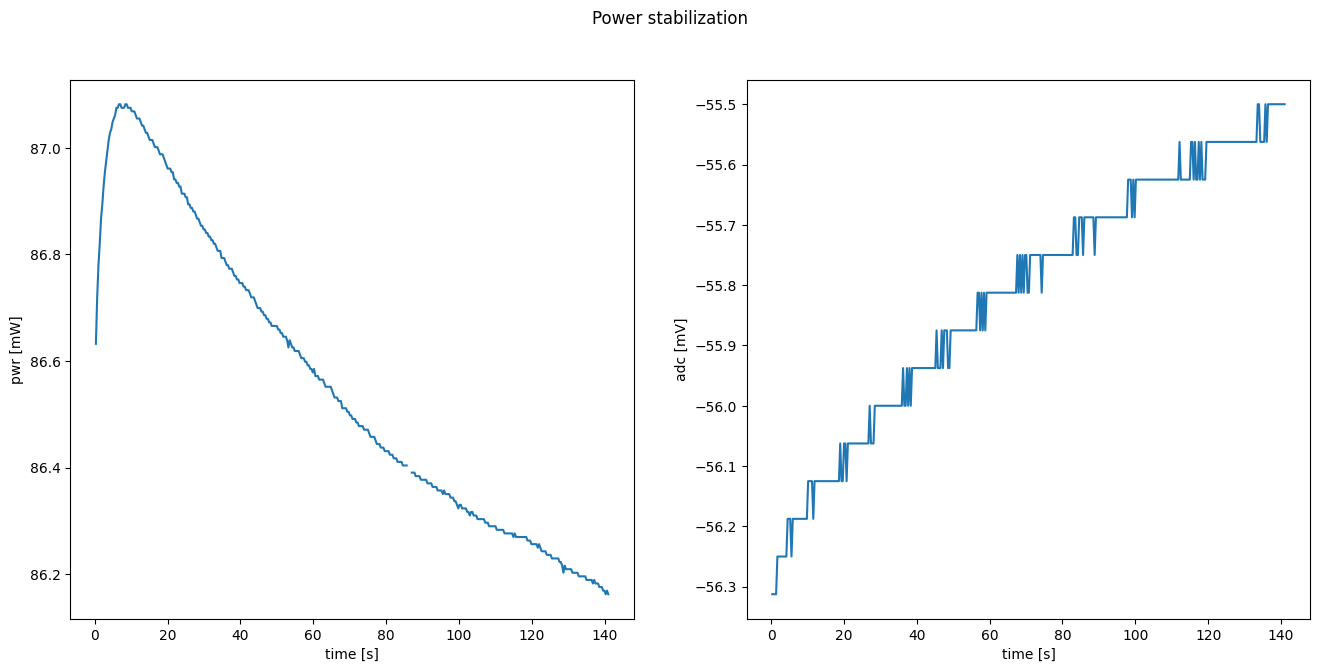

In [109]:
fig, ax = plt.subplots(ncols=2,nrows=N_folders,figsize=(16,7*N_folders))

for i in range(N_folders):
    
    if(N_folders==1):
        ax[0].plot(t_stab[i],pwr_stab[i])
        ax[0].set_xlabel('time [s]')
        ax[0].set_ylabel('pwr [mW]')

        ax[1].plot(t_stab[i],adc_stab[i])
        ax[1].set_xlabel('time [s]')
        ax[1].set_ylabel('adc [mV]')
    
        
    else:
        ax[i,0].plot(t_stab[i],pwr_stab[i])
        ax[i,0].set_xlabel('time [s]')
        ax[i,0].set_ylabel('pwr [mW]')

        ax[i,1].plot(t_stab[i],adc_stab[i])
        ax[i,1].set_xlabel('time [s]')
        ax[i,1].set_ylabel('adc [mV]')
    
fig.suptitle('Power stabilization')

## Voltage Sweep analysis

In [110]:
def get_values(folder_name):    
    
    filenames = glob.glob(folder_name + "/Voltage_sweep/*V.txt")

    # prepare the vectors -------------------------------------------------------------------------
    time_vec = np.zeros(len(filenames),dtype=object)
    pwr_vec = np.zeros(len(filenames),dtype=object)
    adc_vec = np.zeros(len(filenames),dtype=object)
    att_tens = np.zeros(len(filenames))

    pwr_on_vec = np.zeros(len(filenames),dtype=object)
    pwr_off_vec = np.zeros(len(filenames),dtype=object)
    adc_on_vec = np.zeros(len(filenames),dtype=object)
    adc_off_vec = np.zeros(len(filenames),dtype=object)


    # read the data -------------------------------------------------------------------------------
    for fn,i in zip(filenames,range(len(filenames))):
        t,pwr,adc = np.loadtxt(fn,skiprows=4,unpack=True)
        
        time_vec[i] = t
        pwr_vec[i] = pwr 
        adc_vec[i] = adc
        att_tens[i] = float(fn.split("/")[-1].split("V")[0])
    
        pwr_on = []
        pwr_off = []   
    
        adc_on = []
        adc_off = []
    
        if(len(t)>100):

            n_rep = int(len(t)/50)
        
            n=0
            while(n<n_rep):
                pwr_off.append(pwr[n*50:(n+1)*50] )
                pwr_on.append(pwr[(n+1)*50:(n+2)*50] )
            
                adc_off.append(adc[n*50:(n+1)*50])
                adc_on.append(adc[(n+1)*50:(n+2)*50])
            
                n = n+2
            
        pwr_on_vec[i] = pwr_on
        pwr_off_vec[i] = pwr_off
    
        adc_on_vec[i] = adc_on
        adc_off_vec[i] = adc_off
    
    # sort for the attenuator tension ----------------------------------------------------------
    time_vec = time_vec[np.argsort(att_tens)]
    pwr_vec = pwr_vec[np.argsort(att_tens)]
    adc_vec = adc_vec[np.argsort(att_tens)]
    pwr_on_vec = pwr_on_vec[np.argsort(att_tens)]
    pwr_off_vec = pwr_off_vec[np.argsort(att_tens)]
    adc_on_vec = adc_on_vec[np.argsort(att_tens)]
    adc_off_vec = adc_off_vec[np.argsort(att_tens)]
    att_tens = np.sort(att_tens)

    # take the median of the adc, the mean of the pwr and see the delta_p and delta_V-------------------------------------
    avg_pwr = np.zeros(len(att_tens))
    med_adc = np.zeros(len(att_tens))
    std_pwr = np.zeros(len(att_tens))
    delta_adc = np.zeros(len(att_tens))

    for i in range(len(att_tens)):
    
        if(len(pwr_on_vec[i])>0):
        
            print(att_tens[i])
            for pwr_off,pwr_on,adc_off,adc_on in zip(pwr_off_vec[i],pwr_on_vec[i],adc_off_vec[i],adc_on_vec[i]): 
             
                p_off = np.min(pwr_off)
                p_on = np.max(pwr_on)
        
                diff_pwr = p_on-p_off
            
                avg_pwr[i] = np.mean(diff_pwr)
                std_pwr[i] = np.std(diff_pwr)
            
                d_off = np.min(adc_off)
                d_on = np.max(adc_on)
        
                diff_adc = d_on-d_off
            
                med_adc[i] = np.mean(diff_adc)
                delta_adc[i] = np.std(diff_adc)
    
        else:
            avg_pwr[i] = np.average(pwr_vec[i][pwr_vec[i]!=-np.inf])
            std_pwr[i] = np.std(pwr_vec[i][pwr_vec[i]!=-np.inf])
            med_adc[i] = np.median(adc_vec[i])
            delta_adc[i] = abs(np.max(adc_vec[i]) - np.min(adc_vec[i]))
            
    return att_tens,avg_pwr,std_pwr,med_adc,delta_adc

In [111]:
att_tens = np.zeros(N_folders,dtype=object)
avg_pwr = np.zeros(N_folders,dtype=object)
avg_pwr_dBm = np.zeros(N_folders,dtype=object)
std_pwr = np.zeros(N_folders,dtype=object)
med_adc = np.zeros(N_folders,dtype=object)
delta_adc = np.zeros(N_folders,dtype=object)
diode_input_pwr = np.zeros(N_folders,dtype=object)


for i in range(N_folders):

    att_tens[i],avg_pwr[i],std_pwr[i],med_adc[i],delta_adc[i] = get_values(folder_name[i])
    avg_pwr_dBm[i] = mW_to_dBm(avg_pwr[i])
    
    # convert the output power in dBm and correct for the directional coupler:
    pwr_dBm_diode = avg_pwr_dBm[i] - 20 # taking the nominal value from datasheet but the characterization is neeeded.

    # move back to mW
    diode_input_pwr[i] = dBm_to_mW(pwr_dBm_diode)

0.3
0.4
0.5
0.6
0.7
0.8
0.9


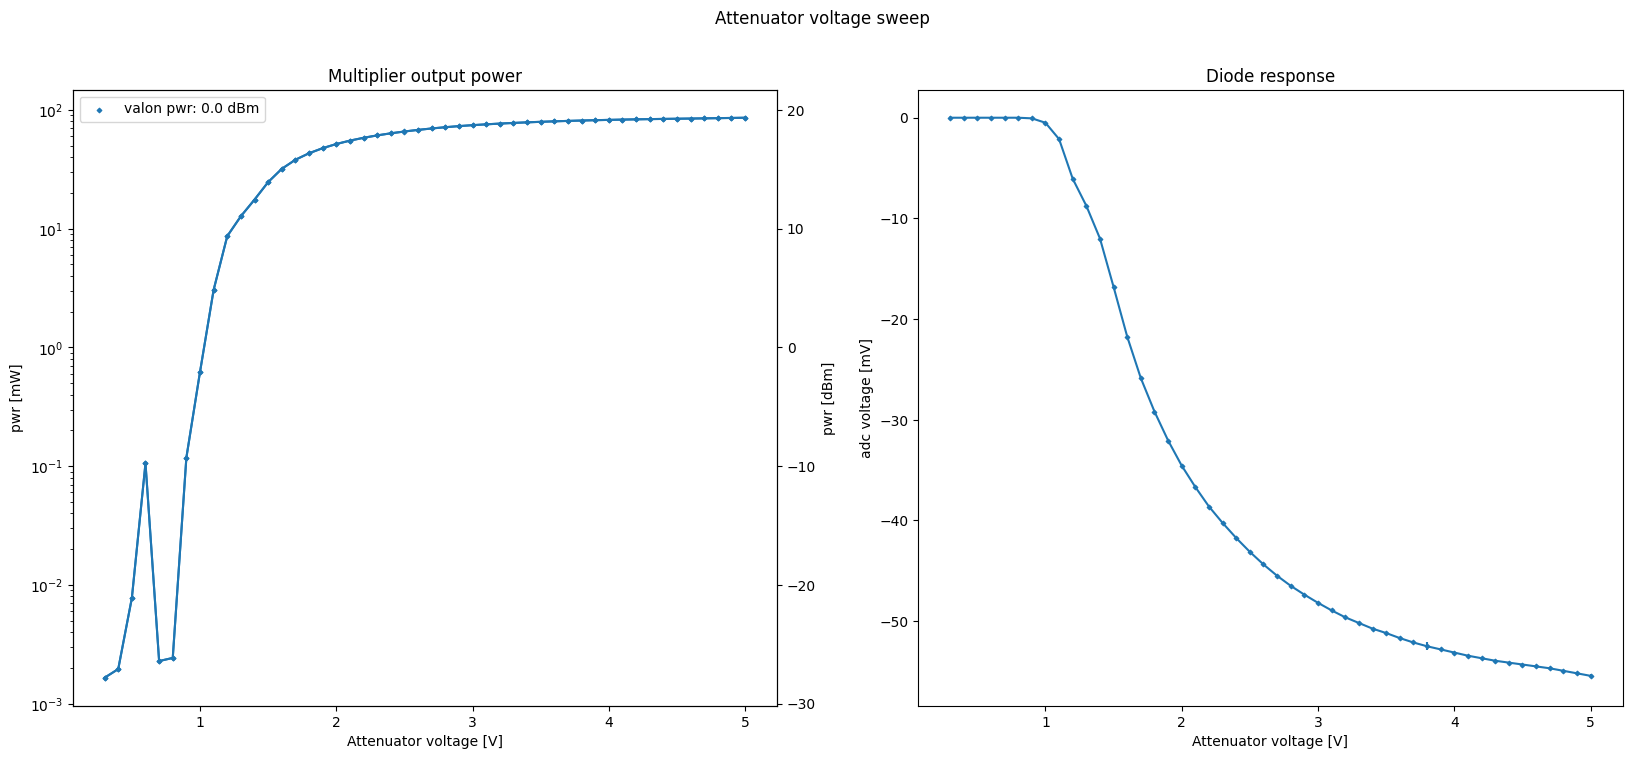

In [112]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,8))

ax2 = ax[0].twinx()

for i in range(N_folders):    

    ax[0].scatter(att_tens[i],avg_pwr[i],marker='D',s=5,label=f"valon pwr: {valon_pwr[i]} dBm")
    ax[0].errorbar(att_tens[i],avg_pwr[i],yerr=std_pwr[i])

    ax[0].set_xlabel('Attenuator voltage [V]')
    ax[0].set_ylabel('pwr [mW]')
    ax[0].set_yscale('log')
    ax[0].set_title('Multiplier output power')
    
    ax2.plot(att_tens[i],avg_pwr_dBm[i])
    ax2.scatter(att_tens[i],avg_pwr_dBm[i],marker='D',s=5)
    
    ax2.set_ylabel('pwr [dBm]')

    ax[1].scatter(att_tens[i],med_adc[i],marker='D',s=5)
    ax[1].errorbar(att_tens[i],med_adc[i],yerr=delta_adc[i])
    ax[1].set_xlabel('Attenuator voltage [V]')
    ax[1].set_ylabel('adc voltage [mV]')
    ax[1].set_title('Diode response')
    
    
fig.suptitle(f'Attenuator voltage sweep')
ax[0].legend()
plt.savefig(folder_name[0]+'/att_voltage_sweep.jpg',format='jpg')

In [105]:
def line(x,m,q):
    return m*x + q

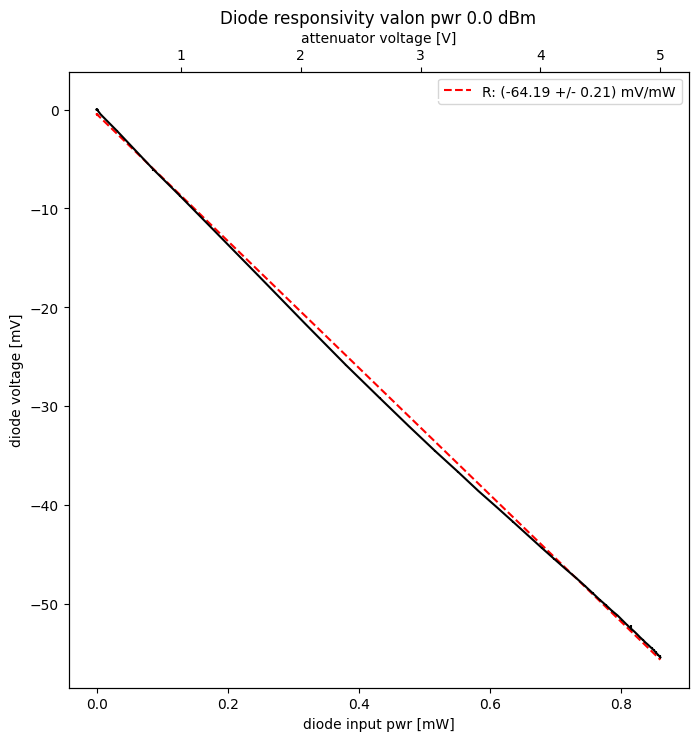

In [97]:
# interpolate a line:

init_params = [60,0]

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for i in range(N_folders):
    
    popt,pcov = scipy.optimize.curve_fit(line,diode_input_pwr[i],med_adc[i],init_params)

    # plot the responsivity:
    #ax1.plot(diode_input_pwr[i],med_adc[i],color='black')
    ax1.errorbar(diode_input_pwr[i],med_adc[i],yerr=delta_adc[i],color='black')
    ax1.set_xlabel('diode input pwr [mW]')
    ax1.set_ylabel('diode voltage [mV]')
    ax1.set_title(f'Diode responsivity valon pwr {valon_pwr[i]} dBm')
    
    ax2.plot(att_tens[i],np.ones(len(att_tens[i])),color='white')
    ax2.set_xlabel('attenuator voltage [V]')
    
    ax1.plot(diode_input_pwr[i],line(diode_input_pwr[i],*popt),color='red',ls='--',label=r'R: (%.2f +/- %.2f) mV/mW'%(popt[0],np.sqrt(pcov[0,0])))
ax1.legend()

plt.savefig(folder_name[0]+'/diode_responsivity.jpg',format='jpg')

plt.show()

In [76]:
dB_pwr_diff[att_tens[2]==1.3]

array([0.08951869])

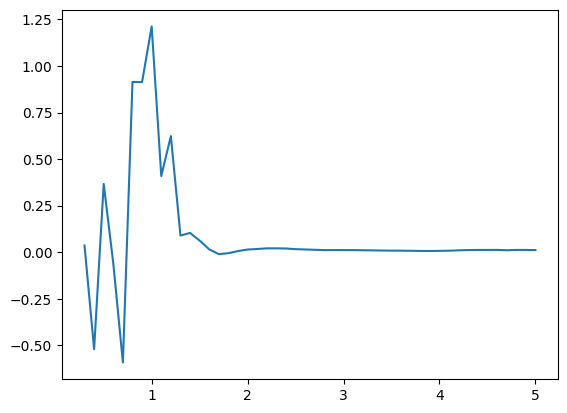

In [74]:
dB_pwr_diff = avg_pwr_dBm[2]-avg_pwr_dBm[1][2:]
plt.plot(att_tens[2],dB_pwr_diff)